# Segment Every Grain

A SAM-based model for instance segmentation of images of grains

<a target="_blank" href="https://colab.research.google.com/github/zsylvester/segmenteverygrain/blob/main/notebooks/Segment_every_grain_colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Install and import packages

### Set up interactive figure backend in Colab

In [ ]:
# this is needed to make figures in Colab interactive
!pip install ipympl
exit(0) # this restarts the runtime after installing ipympl -- otherwise you get an error when switching the matplotlib backend to ipympl

In [1]:
from google.colab import output

output.enable_custom_widget_manager()

In [2]:
%matplotlib ipympl

### Install the other dependencies

In [10]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install segmenteverygrain
!{sys.executable} -m pip install rtree
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tutd1l73
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tutd1l73
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 8.3 MB/s eta 0:00:00


In [6]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from keras.utils import load_img
from keras.saving import load_model
from importlib import reload
import segmenteverygrain as seg
import segmenteverygrain.interactions as si
from tqdm import trange, tqdm

## Download Unet model weights and create Unet model

In [12]:
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/models/seg_model.keras"

--2025-06-30 15:21:35--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/models/seg_model.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26139262 (25M) [application/octet-stream]
Saving to: ‘seg_model.keras’

seg_model.keras     100%[===================>]  24.93M   164MB/s    in 0.2s    

2025-06-30 15:21:36 (164 MB/s) - ‘seg_model.keras’ saved [26139262/26139262]



In [13]:
# UNET model
unet = load_model(
    "seg_model.keras",
    custom_objects={"weighted_crossentropy": seg.weighted_crossentropy},
)

## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pxiels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary).

In [14]:
# get example image
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/examples/barton_creek/barton_creek_image.jpg"

--2025-06-30 15:21:43--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/examples/barton_creek/barton_creek_image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1451152 (1.4M) [image/jpeg]
Saving to: ‘barton_creek_image.jpg’

barton_creek_image. 100%[===================>]   1.38M  --.-KB/s    in 0.07s   

2025-06-30 15:21:43 (20.5 MB/s) - ‘barton_creek_image.jpg’ saved [1451152/1451152]



segmenting image tiles...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


creating masks using SAM...


100%|██████████| 1123/1123 [01:31<00:00, 12.32it/s]


finding overlapping polygons...


1115it [00:19, 56.42it/s]


finding best polygons...


100%|██████████| 309/309 [00:20<00:00, 14.97it/s]


creating labeled image...


100%|██████████| 336/336 [00:03<00:00, 94.08it/s] 


CPU times: user 2min 37s, sys: 1.58 s, total: 2min 38s
Wall time: 2min 39s


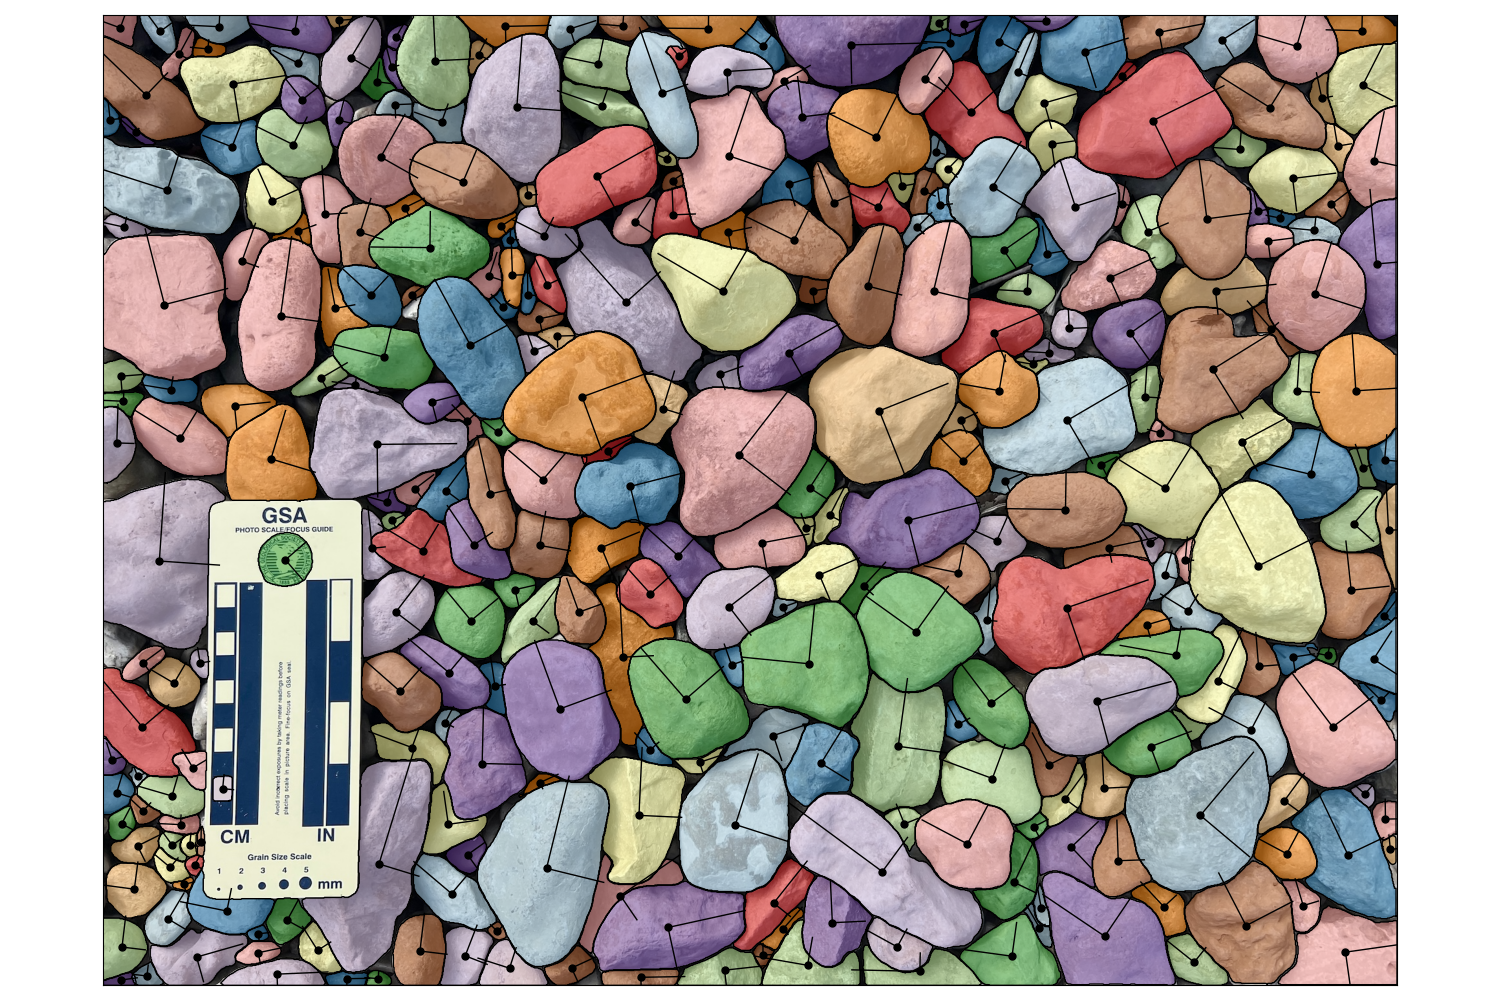

In [15]:
%%time
# replace this with the path to your image:
fname = "barton_creek_image.jpg"
image = np.array(load_img(fname))
image_pred = seg.predict_image(image, unet, I=256)

# decreasing the 'dbs_max_dist' parameter results in more SAM prompts
# (and longer processing times):
labels, coords = seg.label_grains(image, image_pred, dbs_max_dist=20.0)

# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(
    sam,
    image,
    image_pred,
    coords,
    labels,
    min_area=400.0,
    plot_image=True,
    remove_edge_grains=False,
    remove_large_objects=False,
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image_pred)
plt.scatter(np.array(coords)[:, 0], np.array(coords)[:, 1], c="k")
plt.xticks([])
plt.yticks([]);

In [ ]:
# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(
    sam,
    image,
    image_pred,
    coords,
    labels,
    min_area=400.0,
    plot_image=True,
    remove_edge_grains=False,
    remove_large_objects=False,
)

## Interactive editing of segmentation results

**Note:** Interactive editing in Colab may be slower than in a local Jupyter notebook due to network latency.

Convert the polygons to Grain objects and use the interactive `GrainPlot` interface:

**Mouse controls:**
- **Left-click** on existing grain: Select/unselect
- **Left-click** in grain-free area: Instant grain creation
- **Alt + Left-click**: Multi-prompt grain creation
- **Alt + Right-click**: Background prompt for multi-prompt creation
- **Shift + drag**: Draw scale bar for unit conversion
- **Ctrl** (hold): Temporarily hide grain masks

**Keyboard controls:**
- **d**: Delete selected grains
- **m**: Merge selected grains
- **z**: Undo last created grain
- **Esc**: Clear selection and prompts

In [ ]:
# Convert polygons to Grain objects
grains = si.polygons_to_grains(all_grains, image=image)
for g in tqdm(grains, desc='Measuring grains'):
    g.measure()

# Set up SAM predictor for adding new grains
predictor = SamPredictor(sam)
predictor.set_image(image)

# Create interactive plot
# blit=False is required for Colab (ipympl backend doesn't support blitting)
plot = si.GrainPlot(
    grains,
    image=image,
    predictor=predictor,
    blit=False,
    color_palette='Paired',
    figsize=(10, 8),
)
plot.activate()

Run this cell when you are done with interactive editing to retrieve the updated grains and deactivate the interface:

In [ ]:
# Retrieve updated grains and deactivate interactive mode
grains = plot.get_grains()
plot.deactivate()

# Convert Grain objects back to shapely polygons
all_grains = [g.polygon for g in grains]

# Recreate labels from the updated grains
labels, mask_all = seg.create_labeled_image(all_grains, image)

## Get grain size distribution

If you drew a scale bar during interactive editing (Shift + drag), retrieve the scale. Otherwise, manually specify the scale:

In [ ]:
# If you drew a scale bar during editing, get the scale from the plot:
# px_per_m = plot.px_per_m  # pixels per meter

# For 'barton_creek_image.jpg', the scale bar is 10 cm = 374.26 pixels
# So: 374.26 pixels / 0.1 m = 3742.6 pixels per meter
px_per_m = 3742.6  # adjust this for your image

In [ ]:
from skimage.measure import regionprops, regionprops_table

# Calculate units_per_pixel from px_per_m (convert to cm)
units_per_pixel = 100.0 / px_per_m  # cm per pixel

props = regionprops_table(
    labels.astype("int"),
    intensity_image=image,
    properties=(
        "label",
        "area",
        "centroid",
        "major_axis_length",
        "minor_axis_length",
        "orientation",
        "perimeter",
        "max_intensity",
        "mean_intensity",
        "min_intensity",
    ),
)
grain_data = pd.DataFrame(props)
grain_data["major_axis_length"] = (
    grain_data["major_axis_length"].values * units_per_pixel
)
grain_data["minor_axis_length"] = (
    grain_data["minor_axis_length"].values * units_per_pixel
)
grain_data["perimeter"] = grain_data["perimeter"].values * units_per_pixel
grain_data["area"] = grain_data["area"].values * units_per_pixel**2
grain_data.head()

In [ ]:
grain_data.to_csv(fname[:-4] + ".csv")  # save grain data to CSV file

In [ ]:
# plot histogram of grain axis lengths
# note that input data needs to be in milimeters!
# these limits are for 'barton_creek_image.jpg'
fig, ax = seg.plot_histogram_of_axis_lengths(
    grain_data["major_axis_length"] * 10,
    grain_data["minor_axis_length"] * 10,
    binsize=0.4,
    xlimits=[2, 128],
)

## Save mask and grain labels to PNG files

In [ ]:
# write grayscale mask to PNG file
cv2.imwrite(fname.split("/")[-1][:-4] + "_mask.png", mask_all)
# Define a colormap using matplotlib
num_classes = len(all_grains)
cmap = plt.get_cmap("viridis", num_classes)
# Map each class label to a unique color using the colormap
vis_mask = cmap(labels.astype(np.uint16))[:, :, :3] * 255
vis_mask = vis_mask.astype(np.uint8)
# Save the mask as a PNG file
cv2.imwrite(fname.split("/")[-1][:-4] + "_labels.png", vis_mask)
# Save the image as a PNG file
cv2.imwrite(
    fname.split("/")[-1][:-4] + "_image.png", cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
)

## Run segmentation on large image

This function works with images that are larger than a few megapixels and have thousands of grains.
The 'predict_large_image' function breaks the input image into smaller patches and it runs the segmentation process on each patch.

The image used below (from [Mair et al., 2022, Earth Surface Dynamics](https://esurf.copernicus.org/articles/10/953/2022/)) is available [here](https://github.com/zsylvester/segmenteverygrain/blob/main/mair_et_al_L2_DJI_0382_image.jpg).

In [ ]:
# get large example image
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/examples/mair_et_al_L2_DJI_0382/mair_et_al_L2_DJI_0382_image.jpg"

In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None  # needed if working with very large images
fname = "mair_et_al_L2_DJI_0382_image.jpg"
all_grains, image_pred, all_coords = seg.predict_large_image(
    fname, unet, sam, min_area=400.0, patch_size=2000, overlap=200
)

In [ ]:
# plot results
image = np.array(load_img(fname))
fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(image, all_grains, ax, cmap="Paired")